# Example notebook for classification analysis
Originally from: https://github.com/nickwp/watchmal-examples/blob/master/IWCD%20PID%20example%20analysis%20of%20single%20ResNet%20run.ipynb

This notebook contains an example analysis of WatChMaL classification runs, including comparison to fiTQun reconstruction.

Plots are included of the training progression, ROC curves, and various plots of signal or background efficiency vs physical quantities.

In [1]:
# install some additional packages (may need to restart runtime after running this)
!pip install omegaconf uproot hydra-core

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.0/569.0 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.4 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=f01d181cea9820bd15baf82ea1b031293de019b979a005bd6d15d739542ea828
  Stored in directory: /root/.cache/pip/wheels/b1/a3/c2/6df046c09459b73cc9bb6c4401b0be6c47048baf9a1617c485
Successfully built antlr4-python3-runtime


## Imports and setup

First change some display settings for the notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

External imports:

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys
import h5py
import tabulate

Import WatChMaL analysis code

In [4]:
!git clone https://github.com/nickwp/WatChMaL.git
!cd WatChMaL && git checkout analysis_cleanup

Cloning into 'WatChMaL'...
remote: Enumerating objects: 3197, done.
remote: Counting objects: 100% (952/952), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 3197 (delta 728), reused 858 (delta 686), pack-reused 2245
Receiving objects: 100% (3197/3197), 1.00 MiB | 26.97 MiB/s, done.
Resolving deltas: 100% (1743/1743), done.
Branch 'analysis_cleanup' set up to track remote branch 'analysis_cleanup' from 'origin'.
Switched to a new branch 'analysis_cleanup'


In [9]:
!

total 1820372
drwxr-xr-x 4 14361 systemd-network       4096 Jan 26 16:52 17-52-09
-rw-r--r-- 1 root  root            1739269468 Feb  6 20:58 mu_e_gamma.h5
-rw-r--r-- 1 root  root               2122644 Feb  6 20:58 mu_e_gamma_idxs.npz
-rw-r--r-- 1 root  root                104100 Feb  7 18:43 NuPRISMBeamTest_16cShort_mPMT_positions.npz
drwxr-xr-x 1 root  root                  4096 Feb  6 18:44 sample_data
drwxr-xr-x 6 root  root                  4096 Feb  7 18:41 WatChMaL
-rw-r--r-- 1 root  root             122538972 Feb  7 16:22 watchmal_outputs.tar.gz


In [5]:
# either add WatChMaL repository directory to PYTHONPATH environment variable or add it here
sys.path.append('WatChMaL')

In [6]:
import analysis.utils.math as math
from analysis.utils.binning import get_binning, apply_binning
from analysis.utils.plotting import plot_legend
from analysis.classification import WatChMaLClassification, FiTQunClassification, plot_rocs, plot_efficiency_profile, combine_softmax
from analysis.read import FiTQunOutput
#from watchmal.dataset.cnn_mpmt.cnn_mpmt_dataset import CNNmPMTDataset

Imported analysis code from WatChMaL repository with git version: fd9a1db


# Preparing data

## Download the data

In [7]:
# Get the main HDF5 dataset.
!wget -O mu_e_gamma.h5 "https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/EZq_pq6tOGFAguap2kMZZW8BRz1BiM2AijB97zAhexncwQ?e=WdU0nI&download=1"

# Get the indices file.
!wget -O mu_e_gamma_idxs.npz "https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/EeOKfiZBN8hGtzltRNRtNWIBiCTfDHJ3uTtmIirB6ucmug?e=iCrxCg&download=1"

# Get the WatChMaL output directory and un-tar it.
!wget -O watchmal_outputs.tar.gz "https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/ES9B3MhKaY1Bu9nAAwaJbkcBXhyaoaPMmriFRt9c_LHGDw?e=7JFlqg&download=1"
!tar -xvf watchmal_outputs.tar.gz

# Get the mPMT positions file.
!wget -O NuPRISMBeamTest_16cShort_mPMT_positions.npz "https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/EZq_pq6tOGFAguap2kMZZW8BRz1BiM2AijB97zAhexncwQ&download=1"

--2023-02-07 18:42:57--  https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/EZq_pq6tOGFAguap2kMZZW8BRz1BiM2AijB97zAhexncwQ?e=WdU0nI&download=1
Resolving nubeusc-my.sharepoint.com (nubeusc-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to nubeusc-my.sharepoint.com (nubeusc-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/jedward_renner_usc_es/Documents/wcte/sim/mu_e_gamma.h5?ga=1 [following]
--2023-02-07 18:42:58--  https://nubeusc-my.sharepoint.com/personal/jedward_renner_usc_es/Documents/wcte/sim/mu_e_gamma.h5?ga=1
Reusing existing connection to nubeusc-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1739269468 (1.6G) [application/octet-stream]
Saving to: ‘mu_e_gamma.h5’

mu_e_gamma.h5       100%[===================>]   1.62G  51.1MB/s    in 28s     

2023-02-07 18:43:27 (58.2 MB/s) - ‘mu_e_gamma.h5’ saved [1739269468/1739269468]


## Get true particle data from h5 file

In [10]:
# list of particle names to use in filename
#particle_names = ['gamma', 'e-', 'mu-', 'pi0'] # note that the order corresponds to labels 0, 1, 2, 3
particle_names = ['gamma', 'e-', 'mu-'] # note that the order corresponds to labels 0, 1, 2

In [11]:
# get indices of test events
idxs_path = 'mu_e_gamma_idxs.npz'
test_idxs  =  np.load(idxs_path)['test_idxs']

### Open H5 data

In [12]:
# open h5 file and get data for test events
data_path = "mu_e_gamma.h5"
h5_file = h5py.File(data_path, "r")
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()
events_hits_index = np.append(h5_file['event_hits_index'], h5_file['hit_pmt'].shape[0])
h5_nhits      = (events_hits_index[test_idxs+1] - events_hits_index[test_idxs]).squeeze()

In [13]:
h5_directions = math.direction_from_angles(h5_angles)

# Plotting fiTQun and ResNet performance

## Set up plotting style

In [14]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 28}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (12, 9)
matplotlib.rcParams["figure.autolayout"] = True

## Make some cuts to select the events of interest

In [15]:
help(math.towall)

Help on function towall in module analysis.utils.math:

towall(position, angle, tank_half_height=300, tank_radius=400, tank_axis=None)
    Calculate towall: distance from position to detector wall, in particle direction
    
    Parameters
    ----------
    position : array_like
        vector of (x, y, z) position of a particle or (N,3) array of positions for N particles
    angle : array_like
        vector of (zenith, azimuth) direction of particle or (N, 2) array of directions for N particles
    tank_half_height : float, default: 300
        half-height of the detector ID
    tank_radius : float, default: 400
        Radius of the detector ID
    tank_axis : int, optional
        Axis along which the tank cylinder is oriented. By default, use the y-axis.
    
    Returns
    -------
    np.ndarray or scalar
        array of towall values for each position, or scalar if only one position



In [16]:
h5_towall = math.towall(h5_positions, h5_angles, tank_half_height=136.95, tank_radius=172.05)
h5_dwall = math.dwall(h5_positions, tank_half_height=136.95, tank_radius=172.05)
h5_momentum = math.momentum_from_energy(h5_energies, h5_labels)

od_veto_cut = (h5_vetos == 0)
dwall_cut = h5_dwall > -1000
towall_cut = (h5_towall > -1000) & (h5_towall < 1000)
nhits_cut = h5_nhits > 30

h5_gammas = (h5_labels==0)
h5_electrons = (h5_labels==1)
h5_muons = (h5_labels==2)

# select the true electron and muon events that pass the cuts
cuts = ((h5_electrons | h5_muons | h5_gammas)
        #& od_veto_cut
        #& nhit_cut
        #& towall_cut
       )

### xyz (launch vertex)

Text(0.5, 0, 'z (cm)')

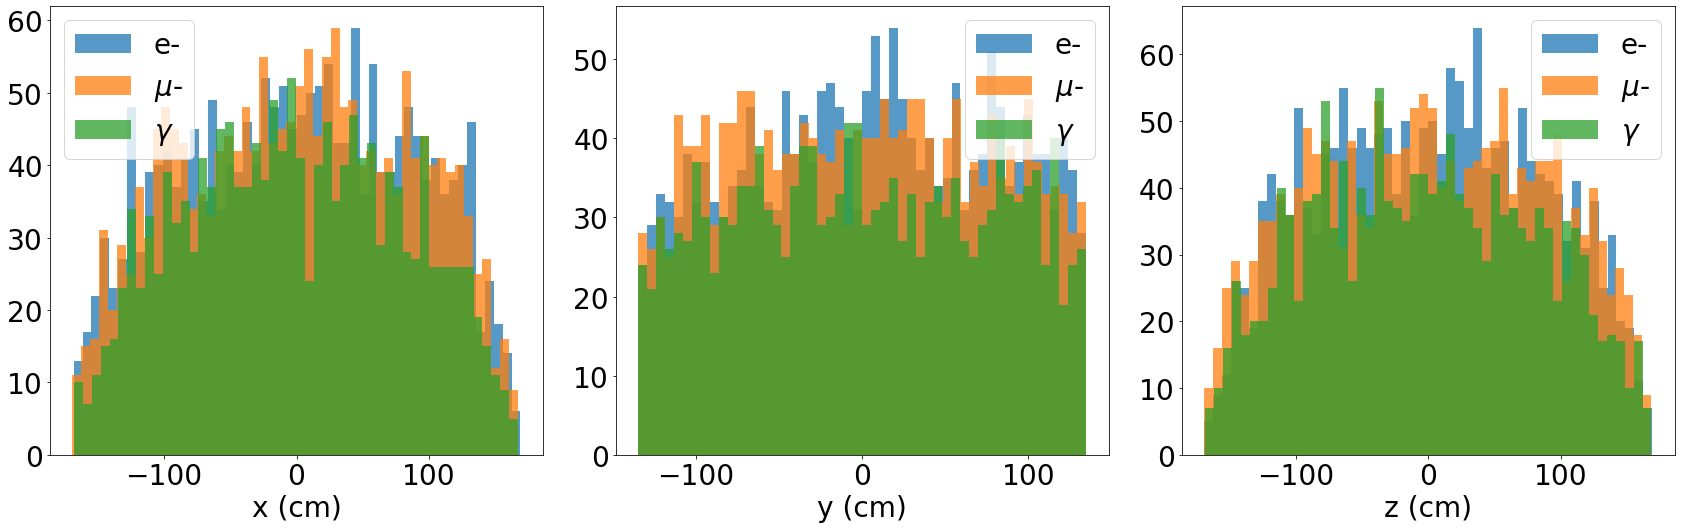

In [17]:
xpos_elec = h5_positions[h5_electrons][:,0]
ypos_elec = h5_positions[h5_electrons][:,1]
zpos_elec = h5_positions[h5_electrons][:,2]

xpos_gamma = h5_positions[h5_gammas][:,0]
ypos_gamma = h5_positions[h5_gammas][:,1]
zpos_gamma = h5_positions[h5_gammas][:,2]

xpos_muon = h5_positions[h5_muons][:,0]
ypos_muon = h5_positions[h5_muons][:,1]
zpos_muon = h5_positions[h5_muons][:,2]

fig = plt.figure()
fig.set_figheight(8.0)
fig.set_figwidth(24.0)

ax1 = fig.add_subplot(131)
ax1.hist(xpos_elec,bins=50,label='e-',alpha=0.75)
ax1.hist(xpos_muon,bins=50,label='$\mu$-',alpha=0.75)
ax1.hist(xpos_gamma,bins=50,label='$\gamma$',alpha=0.75)
ax1.legend()
ax1.set_xlabel("x (cm)")
ax2 = fig.add_subplot(132)
ax2.hist(ypos_elec,bins=50,label='e-',alpha=0.75)
ax2.hist(ypos_muon,bins=50,label='$\mu$-',alpha=0.75)
ax2.hist(ypos_gamma,bins=50,label='$\gamma$',alpha=0.75)
ax2.legend()
ax2.set_xlabel("y (cm)")
ax3 = fig.add_subplot(133)
ax3.hist(zpos_elec,bins=50,label='e-',alpha=0.75)
ax3.hist(zpos_muon,bins=50,label='$\mu$-',alpha=0.75)
ax3.hist(zpos_gamma,bins=50,label='$\gamma$',alpha=0.75)
ax3.legend()
ax3.set_xlabel("z (cm)")

Text(0, 0.5, 'nhits')

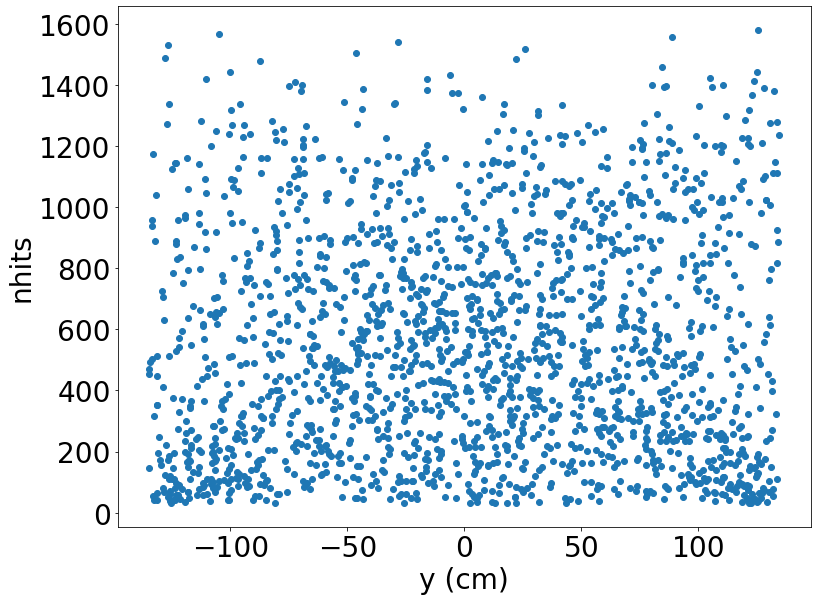

In [18]:
plt.scatter(ypos_elec,h5_nhits[h5_electrons])
plt.xlabel("y (cm)")
plt.ylabel("nhits")

### xyz direction

Text(0.5, 0, 'dir-z')

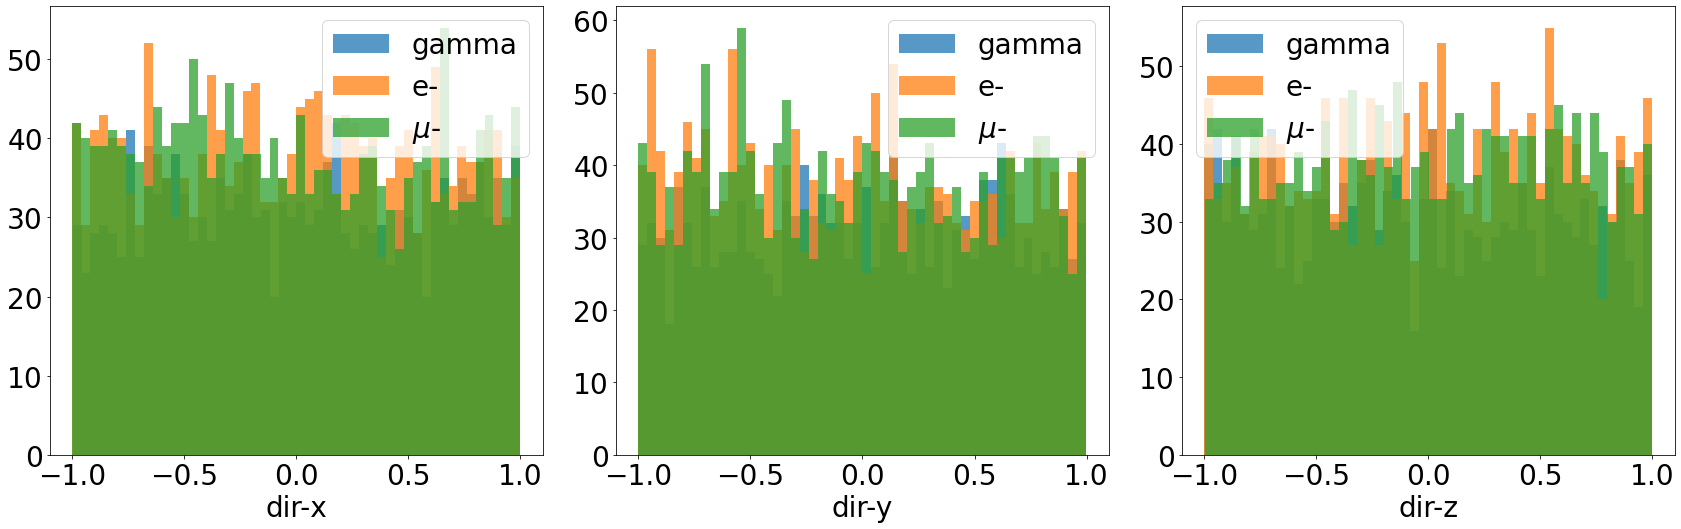

In [19]:
xdir_gamma = h5_directions[h5_gammas][:,0]
ydir_gamma = h5_directions[h5_gammas][:,1]
zdir_gamma = h5_directions[h5_gammas][:,2]

xdir_elec = h5_directions[h5_electrons][:,0]
ydir_elec = h5_directions[h5_electrons][:,1]
zdir_elec = h5_directions[h5_electrons][:,2]

xdir_muon = h5_directions[h5_muons][:,0]
ydir_muon = h5_directions[h5_muons][:,1]
zdir_muon = h5_directions[h5_muons][:,2]

fig = plt.figure()
fig.set_figheight(8.0)
fig.set_figwidth(24.0)

ax1 = fig.add_subplot(131)
ax1.hist(xdir_gamma,bins=50,label='gamma',alpha=0.75)
ax1.hist(xdir_elec,bins=50,label='e-',alpha=0.75)
ax1.hist(xdir_muon,bins=50,label='$\mu$-',alpha=0.75)
ax1.legend()
ax1.set_xlabel("dir-x")
ax2 = fig.add_subplot(132)
ax2.hist(ydir_gamma,bins=50,label='gamma',alpha=0.75)
ax2.hist(ydir_elec,bins=50,label='e-',alpha=0.75)
ax2.hist(ydir_muon,bins=50,label='$\mu$-',alpha=0.75)
ax2.legend()
ax2.set_xlabel("dir-y")
ax3 = fig.add_subplot(133)
ax3.hist(zdir_gamma,bins=50,label='gamma',alpha=0.75)
ax3.hist(zdir_elec,bins=50,label='e-',alpha=0.75)
ax3.hist(zdir_muon,bins=50,label='$\mu$-',alpha=0.75)
ax3.legend()
ax3.set_xlabel("dir-z")

### Energy

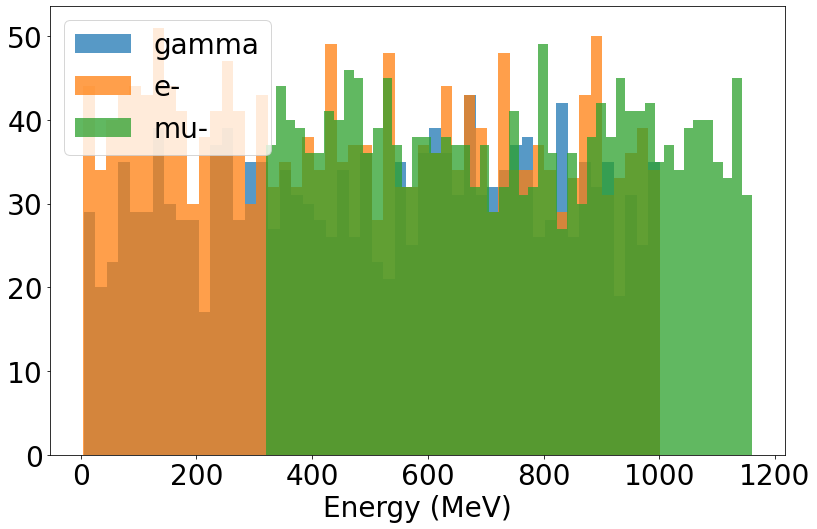

In [20]:
en_gamma = h5_energies[h5_gammas]
en_elec = h5_energies[h5_electrons]
en_muon = h5_energies[h5_muons]

fig = plt.figure()
fig.set_figheight(8.0)
fig.set_figwidth(12.0)

plt.hist(en_gamma,bins=50,label='gamma',alpha=0.75)
plt.hist(en_elec,bins=50,label='e-',alpha=0.75)
plt.hist(en_muon,bins=50,label='mu-',alpha=0.75)
plt.xlabel("Energy (MeV)")
plt.legend()

### towall

Text(0.5, 0, 'dwall (cm)')

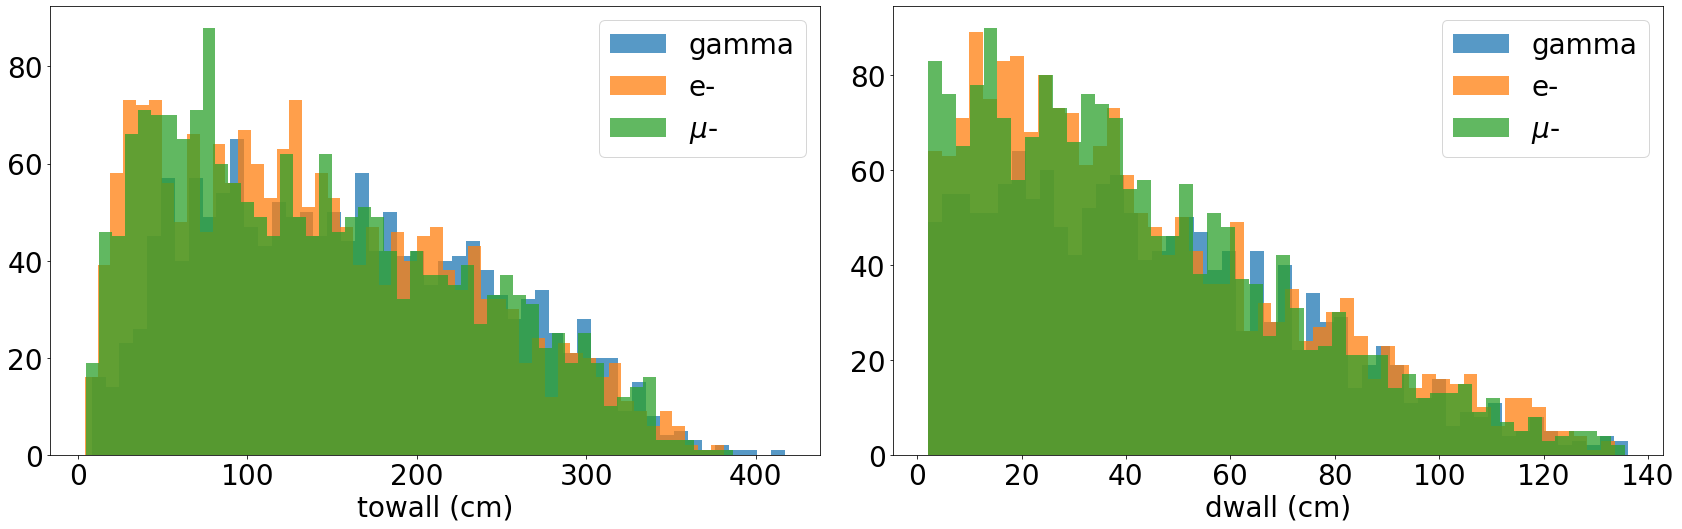

In [21]:
towall_gamma = h5_towall[(h5_gammas & cuts)]
towall_elec = h5_towall[(h5_electrons & cuts)]
towall_muon = h5_towall[(h5_muons & cuts)]
dwall_gamma = h5_dwall[(h5_gammas & cuts)]
dwall_elec = h5_dwall[(h5_electrons & cuts)]
dwall_muon = h5_dwall[(h5_muons & cuts)]

fig = plt.figure()
fig.set_figheight(8.0)
fig.set_figwidth(24.0)

ax1 = fig.add_subplot(121)
ax1.hist(towall_gamma,bins=50,label='gamma',alpha=0.75)
ax1.hist(towall_elec,bins=50,label='e-',alpha=0.75)
ax1.hist(towall_muon,bins=50,label='$\mu$-',alpha=0.75)
ax1.legend()
ax1.set_xlabel("towall (cm)")
ax2 = fig.add_subplot(122)
ax2.hist(dwall_gamma,bins=50,label='gamma',alpha=0.75)
ax2.hist(dwall_elec,bins=50,label='e-',alpha=0.75)
ax2.hist(dwall_muon,bins=50,label='$\mu$-',alpha=0.75)
ax2.legend()
ax2.set_xlabel("dwall (cm)")

## Bin events in various quantities

Here we use the binning functions that allow us to bin events by various quantities:

In [22]:
help(get_binning)

Help on function get_binning in module analysis.utils.binning:

get_binning(x, bins=None, minimum=None, maximum=None, width=None)
    Finds the indices of the bins to which each value in input array belongs, for a set of bins specified either as an
    array of bin edges, number of bins or bin width
    
    Parameters
    ----------
    x: array_like
        Input array to be binned.
    bins: array_like, optional
        If `bins` is an int, it defines the number of equal-width bins in the range (200, by default). If `bins` is an
        array, it is the array of bin edges and must be 1-dimensional and monotonic.
    minimum: int or real, optional
        Lowest bin lower edge (by default use minimum value in `x`). Not used if `bins` is an ndarray of bin edges.
    maximum: int or real, optional
        Highest bin upper edge (by default use minimum value in `x`). Not used if `bins` is an ndarray of bin edges.
    width: int or real, optional
        Width of bins to generate equal w

In [23]:
mom_binning = get_binning(h5_momentum, 17, 150, 1000)
cos_zenith_binning = get_binning(np.cos(h5_angles[:,0]), 20, -1, 1)
azimuth_binning = get_binning(h5_angles[:,1]*180/np.pi, 20, -180, 180)
dwall_binning = get_binning(h5_dwall, 22, 50, 300)
towall_binning = get_binning(h5_towall, 30, 50, 800)

# Electron / muon / gamma

## Load results
### Load ResNet and fiTQun results

Here we set up an instance of the classification class for WatChMaL outputs:

In [ ]:
help(WatChMaLClassification)

In [24]:
resnet_run = WatChMaLClassification("17-52-09", "ResNet", h5_labels, test_idxs, cuts, color="blue", linestyle='-')

### Plot training progression

In [25]:
help(WatChMaLClassification.plot_training_progression)

Help on function plot_training_progression in module analysis.classification:

plot_training_progression(self, plot_best=True, y_loss_lim=None, fig_size=None, title=None, legend='center right')
    Plot the progression of training and validation loss and accuracy from the run's logs
    
    Parameters
    ----------
    plot_best: bool, optional
        If true (default), plot points indicating the best validation loss and accuracy
    y_loss_lim: (int, int), optional
        Range for the loss y-axis. By default, the range will expand to show all loss values in the logs.
    fig_size: (float, float), optional
        Size of the figure
    title: str, optional
        Title of the figure. By default, do not plot a title.
    legend: str, optional
        Position to plot the legend. By default, the legend is placed in the center right. For no legend use `None`.
    
    Returns
    -------
    matplotlib.figure.Figure
    matplotlib.axes.Axes



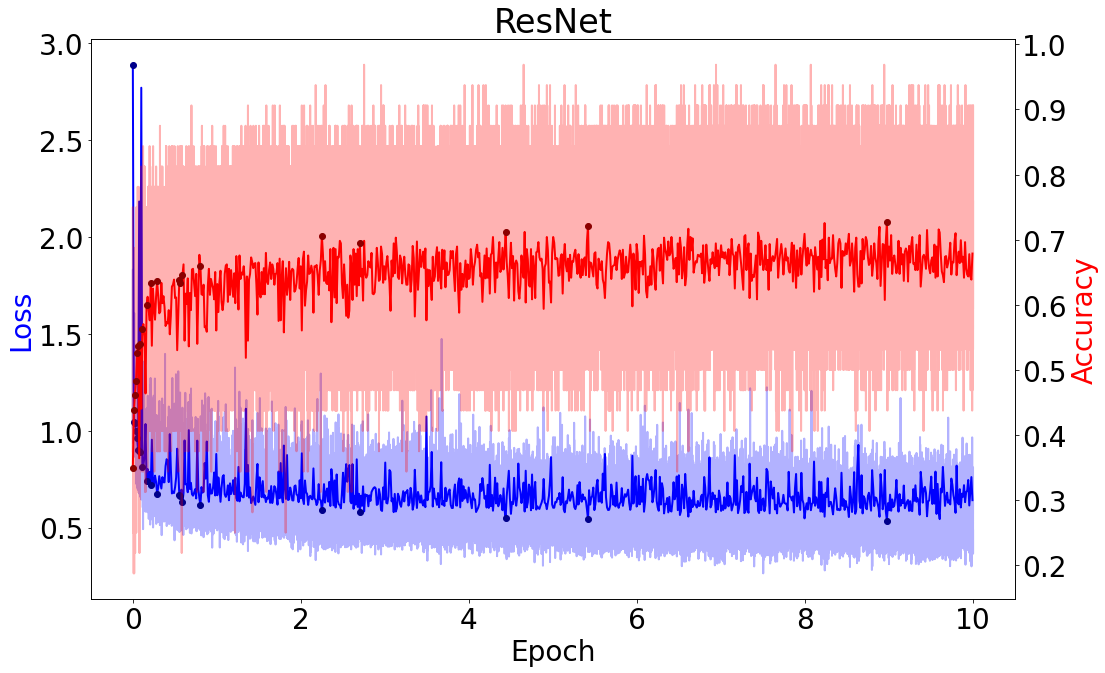

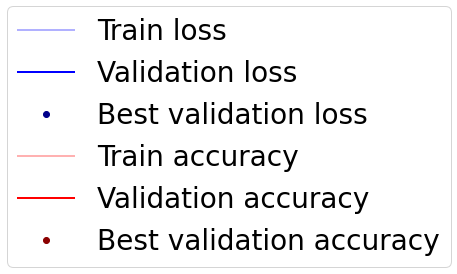

In [26]:
fig, ax1, ax2, = resnet_run.plot_training_progression(legend=None, fig_size=(16,10), title=resnet_run.run_label)
leg_fig, leg_ax = plot_legend((ax1, ax2))

## Plot results

### Plot histograms of the predicted probabilities
For electron vs muon probabilities, in a 4-class model with gammas (which are also considered electron-like) we need to combine the electron and gamma softmaxes to get the electron-like probability.
The discriminator method used below automatically calulates the signal probability from the softmax values of the given signal and background labels.

In [ ]:
help(WatChMaLClassification.discriminator)

In [27]:
# 0 --> gamma (ID 22)
# 1 --> electron (ID 11)
# 2 --> muon (ID 13)
gamma_labels = [0]
e_labels = [1]
mu_labels = [2]

type1_labels = [1]
type2_labels = [0]

type1 = "electron"
type2 = "gamma"

# e vs. gamma
type1_probabilities = resnet_run.discriminator(type1_labels, type2_labels)
type2_probabilities = resnet_run.discriminator(type2_labels, type1_labels)

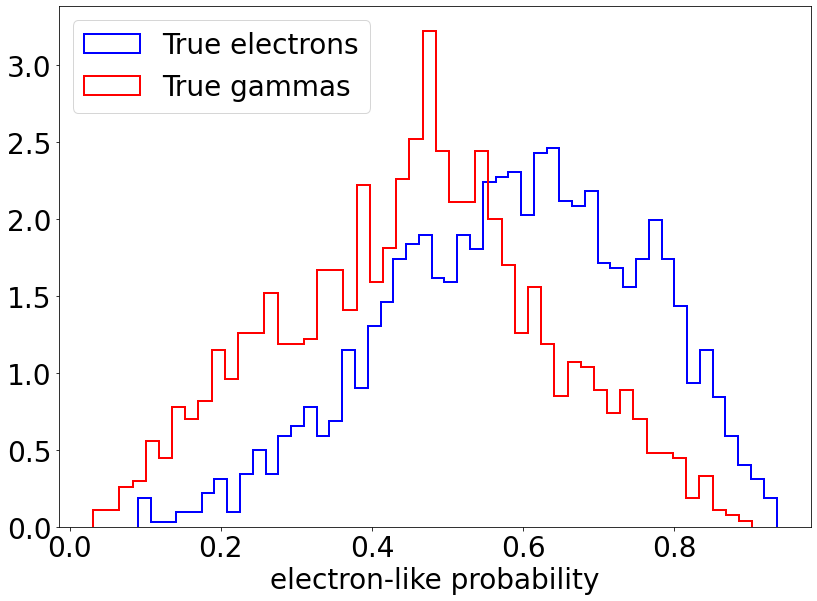

In [28]:
fig, ax = plt.subplots()
ax.hist(type1_probabilities[(h5_electrons)], density=True, histtype='step', lw=2, color='blue', bins=50, label='True electrons')
ax.hist(type1_probabilities[h5_gammas], density=True, histtype='step', lw=2, color='red', bins=50, label='True gammas')
ax.set_xlabel("{}-like probability".format(type1))
ax.legend(loc=2)

### ROC curve for electron signal vs muon rejection

The `plot_rocs` function allows plotting overlaid ROC curves for a chosen signal and background classification.

In [ ]:
help(plot_rocs)

We plot using a few different formats for viewing the ROC data.

Note that in several of the plotting functions, we pass a list of runs (here just containing a single run, i.e. `[resnet_run]`). To make plots comparing multiple classification runs, for example with different network architectures or hyperparameters, you can simply replace this with a list containing more than one run.

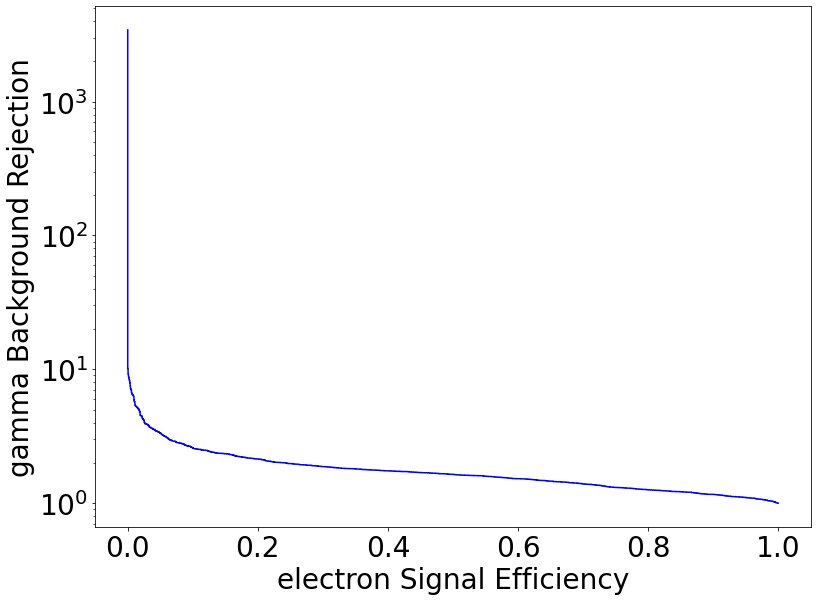

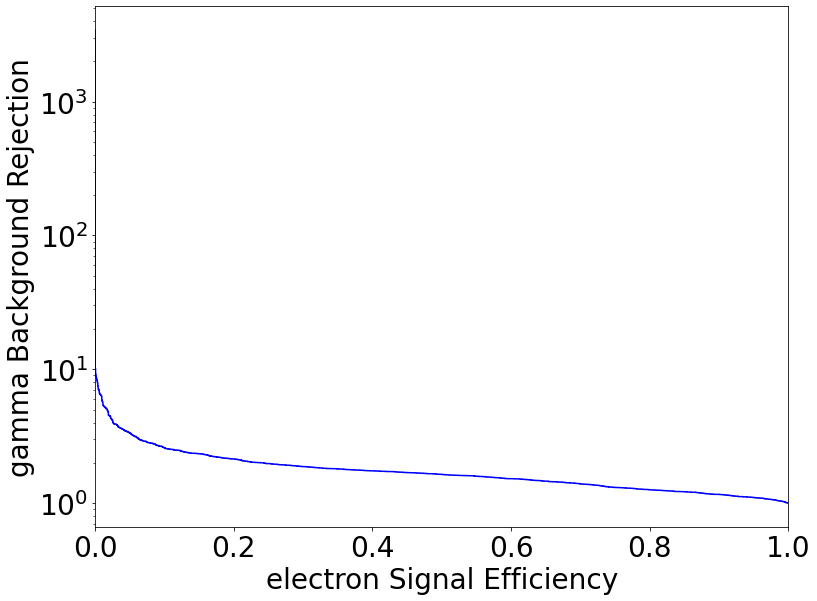

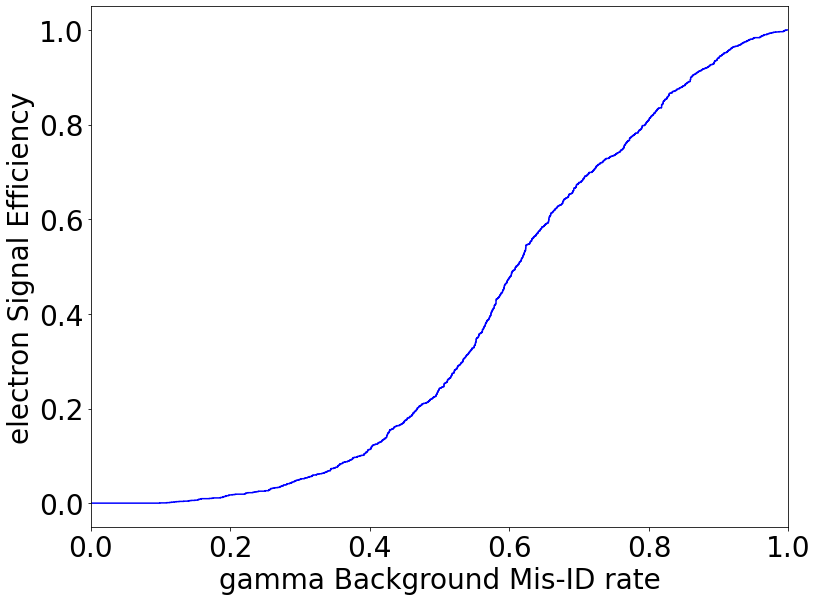

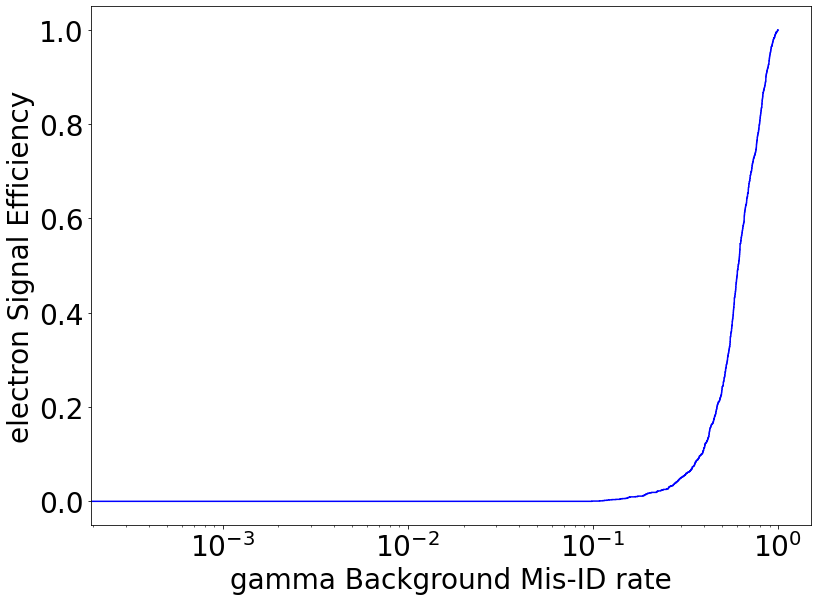

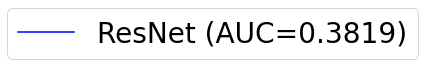

In [29]:
fig, ax = plot_rocs([resnet_run], type1_labels, type2_labels, x_label="{} Signal Efficiency".format(type1), y_label="{} Background Rejection".format(type2), mode='rejection', legend=None)
fig, ax = plot_rocs([resnet_run], type1_labels, type2_labels, x_label="{} Signal Efficiency".format(type1), y_label="{} Background Rejection".format(type2), mode='rejection', x_lim=(0.0,1), legend=None)
fig, ax = plot_rocs([resnet_run], type1_labels, type2_labels, x_label="{} Background Mis-ID rate".format(type2), y_label="{} Signal Efficiency".format(type1), mode='efficiency', x_lim=(0,1.0), legend=None)
fig, ax = plot_rocs([resnet_run], type1_labels, type2_labels, x_label="{} Background Mis-ID rate".format(type2), y_label="{} Signal Efficiency".format(type1), mode='efficiency', x_log=True, legend=None)
l_fig, l_ax = plot_legend(ax)

###  for fixed 0.1% muon mis-ID

### for each 50 MeV bin of reconstructed momentum, calculate the thresholds that reject 99.9% of muons and apply cut to all events

In [ ]:
help(WatChMaLClassification.cut_with_fixed_efficiency)

In [30]:
type2_rejection = 0.999
type2_efficiency = 1-type2_rejection
resnet_run.cut_with_fixed_efficiency(type1_labels, type2_labels, type2_efficiency, select_labels=type2_labels)

array([False, False, False, ...,  True, False, False])

### Plot signal efficiency against true momentum, dwall, towall, zenith, azimuth

In [ ]:
help(plot_efficiency_profile)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


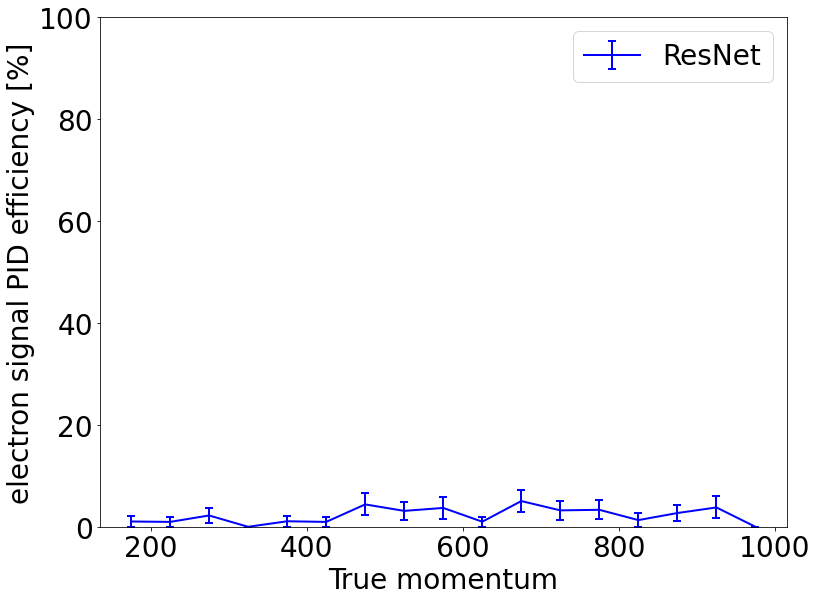

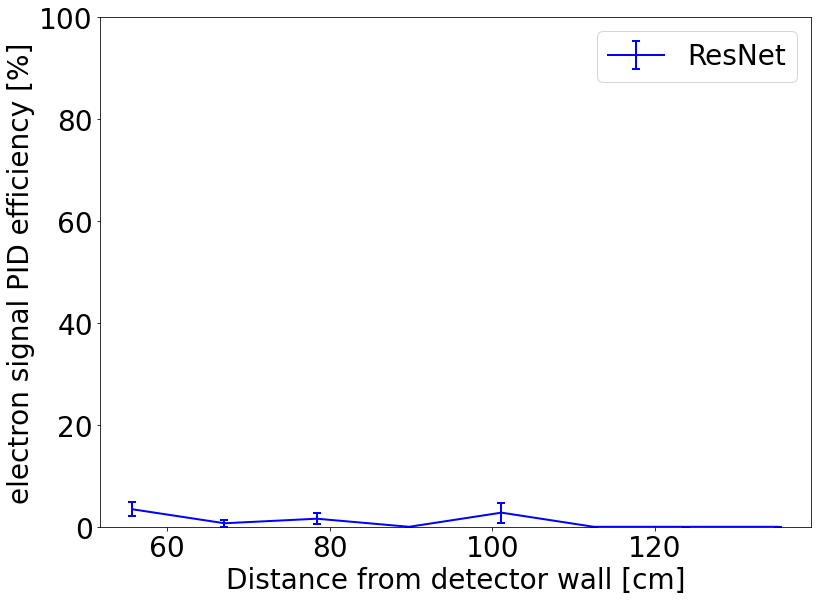

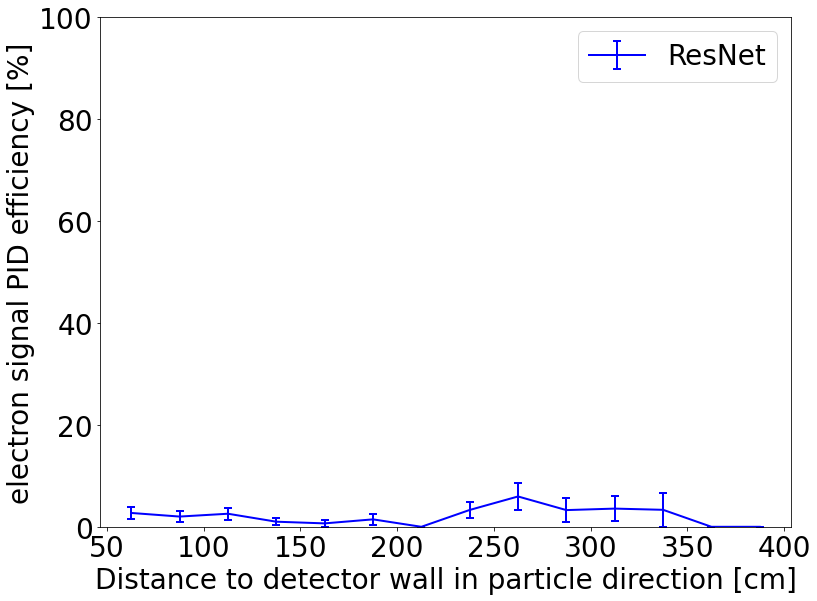

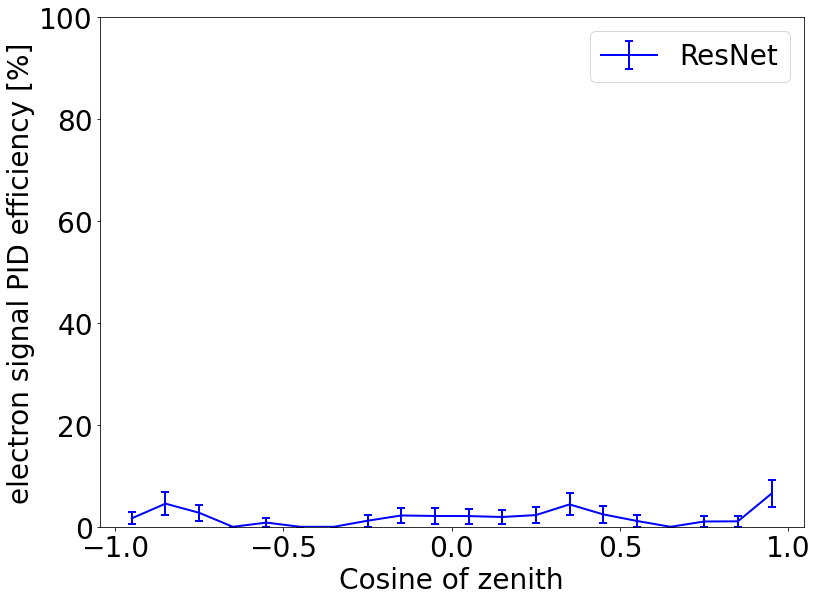

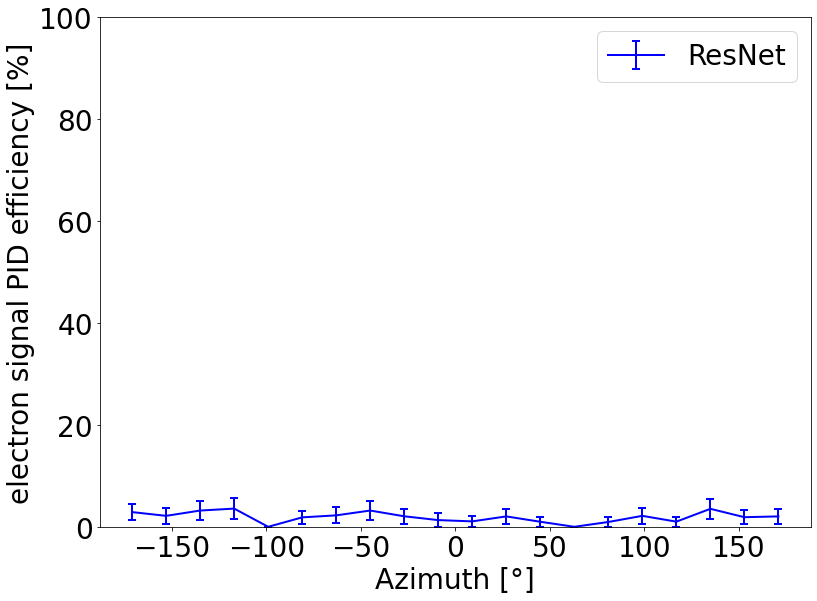

In [31]:
fig, ax = plot_efficiency_profile([resnet_run], mom_binning, select_labels=type1_labels, x_label="True momentum", y_label="{} signal PID efficiency [%]".format(type1), errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile([resnet_run], dwall_binning, select_labels=type1_labels, x_label="Distance from detector wall [cm]", y_label="{} signal PID efficiency [%]".format(type1), errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile([resnet_run], towall_binning, select_labels=type1_labels, x_label="Distance to detector wall in particle direction [cm]", y_label="{} signal PID efficiency [%]".format(type1), errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile([resnet_run], cos_zenith_binning, select_labels=type1_labels, x_label="Cosine of zenith", y_label="{} signal PID efficiency [%]".format(type1), errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile([resnet_run], azimuth_binning, select_labels=type1_labels, x_label="Azimuth [°]", y_label="{} signal PID efficiency [%]".format(type1), errors=True, x_errors=False, y_lim=(0,100))

### Plot background mis-ID against true momentum, dwall, towall, zenith, azimuth

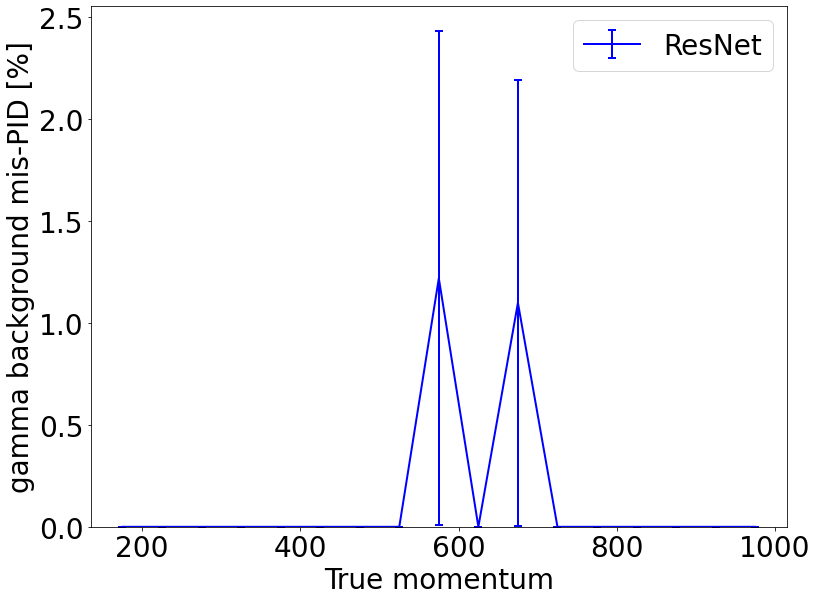

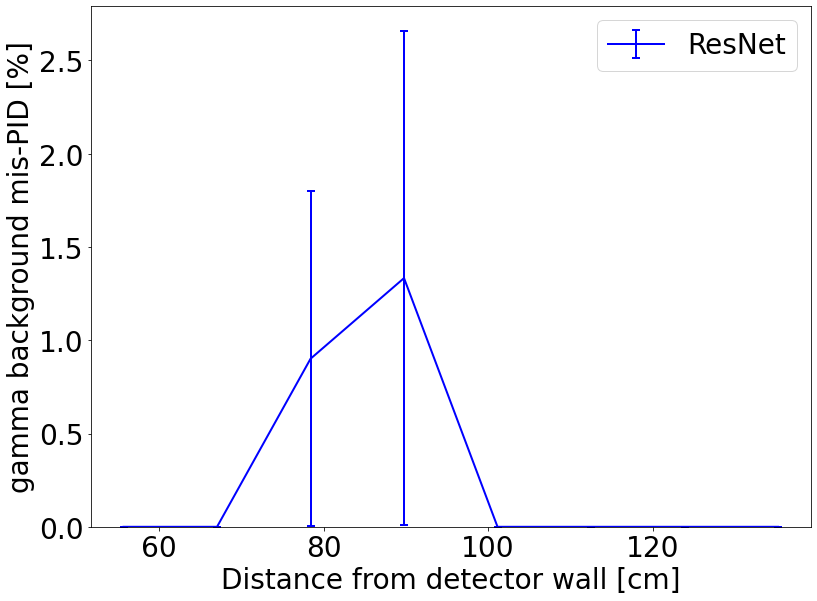

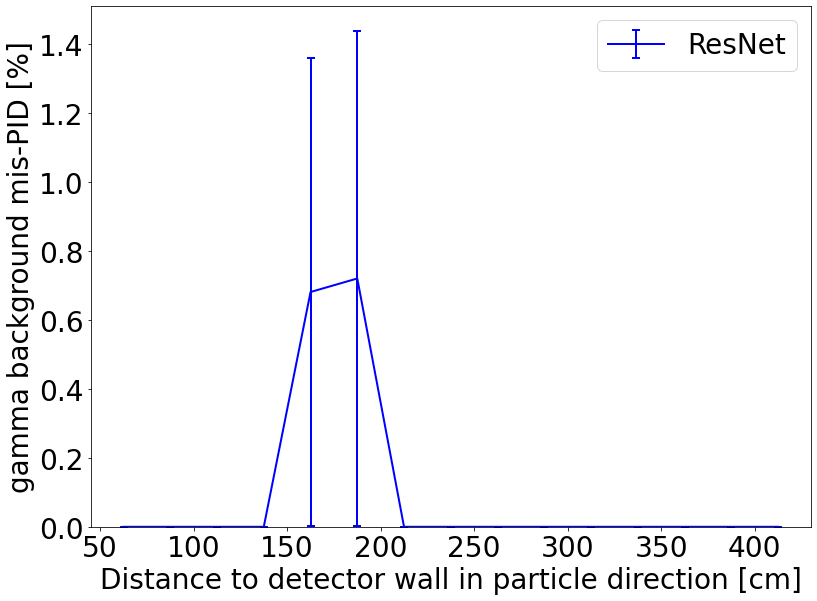

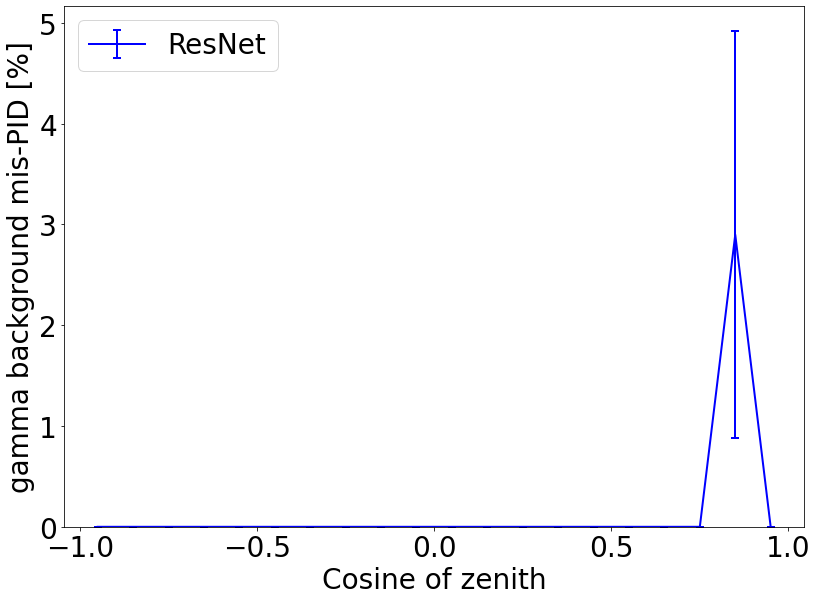

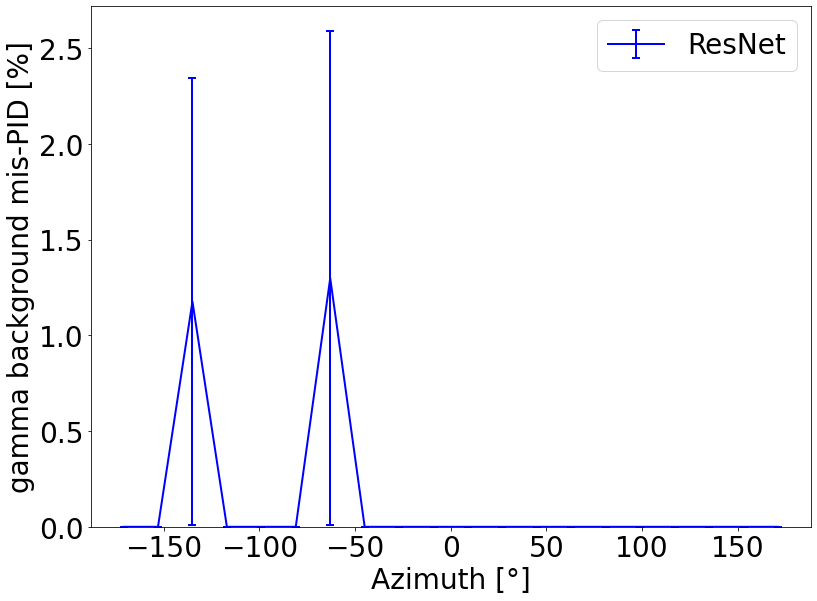

In [32]:
fig, ax = plot_efficiency_profile([resnet_run], mom_binning, select_labels=type2_labels, x_label="True momentum", y_label="{} background mis-PID [%]".format(type2), errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run], dwall_binning, select_labels=type2_labels, x_label="Distance from detector wall [cm]", y_label="{} background mis-PID [%]".format(type2), errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run], towall_binning, select_labels=type2_labels, x_label="Distance to detector wall in particle direction [cm]", y_label="{} background mis-PID [%]".format(type2), errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run], cos_zenith_binning, select_labels=type2_labels, x_label="Cosine of zenith", y_label="{} background mis-PID [%]".format(type2), errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run], azimuth_binning, select_labels=type2_labels, x_label="Azimuth [°]", y_label="{} background mis-PID [%]".format(type2), errors=True, x_errors=False, y_lim=0)

# Plot individual events (not ready for use yet)

In [ ]:
# import os
# import torch
# os.environ['TORCH'] = torch.__version__
# print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
#dataset_wcte = CNNmPMTDataset(h5file="mu_e_gamma.h5", mpmt_positions_file="NuPRISMBeamTest_16cShort_mPMT_positions.npz")